# The Simplest Graph


![Screenshot 2024-08-20 at 3.11.22 PM.png](https://cdn.prod.website-files.com/65b8cd72835ceeacd4449a53/66dba5f465f6e9a2482ad935_simple-graph1.png)

## State

First, define the [State](https://langchain-ai.github.io/langgraph/concepts/low_level/#state) of the graph. 

The State schema serves as the input schema for all Nodes and Edges in the graph.

Let's use the `TypedDict` class from python's `typing` module as our schema, which provides type hints for the keys.

In [1]:
from typing_extensions import TypedDict

class State(TypedDict):
    graph_state: str

## Nodes

[Nodes](https://langchain-ai.github.io/langgraph/concepts/low_level/#nodes) are just python functions.

The first positional argument is the state, as defined above.

Because the state is a `TypedDict` with schema as defined above, each node can access the key, `graph_state`, with `state['graph_state']`.

Each node returns a new value of the state key `graph_state`.
  
By default, the new value returned by each node [will override](https://langchain-ai.github.io/langgraph/concepts/low_level/#reducers) the prior state value.

In [31]:
def node_1(state):
    print("---Node 1---")
    return {"graph_state": state['graph_state'] +" Я мав"}

def node_2(state):
    print("---Node 2---")
    return {"graph_state": state['graph_state'] +"па рижа!"}

def node_3(state):
    print("---Node 3---")
    return {"graph_state": state['graph_state'] +" Парижа!"}

## Edges

[Edges](https://langchain-ai.github.io/langgraph/concepts/low_level/#edges) connect the nodes.

Normal Edges are used if you want to *always* go from, for example, `node_1` to `node_2`.

[Conditional Edges](https://langchain-ai.github.io/langgraph/concepts/low_level/#conditional-edges) are used if you want to *optionally* route between nodes.
 
Conditional edges are implemented as functions that return the next node to visit based upon some logic.

In [10]:
import random
from typing import Literal

def decide_mood(state) -> Literal["node_2", "node_3"]:
    
    # Often, we will use state to decide on the next node to visit
    user_input = state['graph_state'] 
    
    # Here, let's just do a 50 / 50 split between nodes 2, 3
    if random.random() < 0.5:

        # 50% of the time, we return Node 2
        return "node_2"
    
    # 50% of the time, we return Node 3
    return "node_3"

## Graph Construction

Now, we build the graph from our [components](
https://langchain-ai.github.io/langgraph/concepts/low_level/) defined above.

The [StateGraph class](https://langchain-ai.github.io/langgraph/concepts/low_level/#stategraph) is the graph class that we can use.
 
First, we initialize a StateGraph with the `State` class we defined above.
 
Then, we add our nodes and edges.

We use the [`START` Node, a special node](https://langchain-ai.github.io/langgraph/concepts/low_level/#start-node) that sends user input to the graph, to indicate where to start our graph.
 
The [`END` Node](https://langchain-ai.github.io/langgraph/concepts/low_level/#end-node) is a special node that represents a terminal node. 

Finally, we [compile our graph](https://langchain-ai.github.io/langgraph/concepts/low_level/#compiling-your-graph) to perform a few basic checks on the graph structure. 

We can visualize the graph as a [Mermaid diagram](https://github.com/mermaid-js/mermaid).

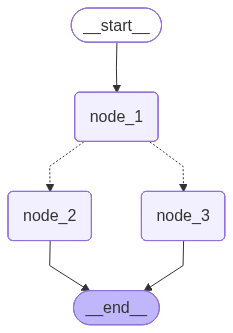

In [32]:
from IPython.display import Image, display
from langgraph.graph import StateGraph, START, END

# Build graph
builder = StateGraph(State)
builder.add_node("node_1", node_1)
builder.add_node("node_2", node_2)
builder.add_node("node_3", node_3)

# Logic
builder.add_edge(START, "node_1")
builder.add_conditional_edges("node_1", decide_mood)
builder.add_edge("node_2", END)
builder.add_edge("node_3", END)

# Add
graph = builder.compile()

# View
display(Image(graph.get_graph().draw_mermaid_png()))

## Graph Invocation

The compiled graph implements the [runnable](https://python.langchain.com/docs/concepts/runnables/) protocol.

This provides a standard way to execute LangChain components. 
 
`invoke` is one of the standard methods in this interface.


When `invoke` is called, the graph starts execution from the `START` node.

It progresses through the defined nodes (`node_1`, `node_2`, `node_3`) in order.

The conditional edge will traverse from node `1` to node `2` or `3` using a 50/50 decision rule. 

Each node function receives the current state and returns a new value, which overrides the graph state.

The execution continues until it reaches the `END` node.

In [75]:
graph.invoke({"graph_state" : "Привіт"})

---Node 1---
---Node 3---


{'graph_state': 'Привіт Я мав Парижа!'}

`invoke` runs the entire graph synchronously.

This waits for each step to complete before moving to the next.

It returns the final state of the graph after all nodes have executed.

In this case, it returns the state after `node_3` has completed: 

```
{'graph_state': 'Привіт Я мав Парижа!'}
```

# First agent

In [1]:
import os
from dotenv import load_dotenv

from typing import TypedDict, List, Dict, Any, Optional
from langgraph.graph import StateGraph, START, END
from langchain_openai import ChatOpenAI
from langchain_core.messages import HumanMessage
import requests
from striprtf.striprtf import rtf_to_text
from langchain_core.tools import tool
from langchain_core.prompts import PromptTemplate
from typing import Annotated
from langgraph.graph.message import add_messages
from langchain_core.messages import AnyMessage


load_dotenv()
api_key = os.getenv("OPENAI_API_KEY")
model = ChatOpenAI(model="gpt-4o", temperature=0)

In [16]:
url = "http://od.reyestr.court.gov.ua/files/61/520ce2d5f53b2a22eafd30fca9c17d43.rtf"
url2 = "http://od.reyestr.court.gov.ua/files/58/6c270e909170b7e67afc1ec93ef5cabe.rtf"

In [3]:
class AgentState(TypedDict):
    url: str
    text: str
    summary: str

In [20]:
summary_prompt = """
Summarize the following text {text} in one short sentence. Summarize in ukrainian.
"""

In [5]:
def extract_rtf_text(state: AgentState) -> str:
    """
    Download an RTF document from the given URL and extract plain text from it.
    """

    url = state["url"]
    response = requests.get(url)
    response.raise_for_status()

    rtf_content = response.content.decode("utf-8", errors="ignore")

    text = rtf_to_text(rtf_content)
    return  {"text": text}


def summarize_text(text: str) -> str:
    """
    Summarizes the given text using the LLM.
    
    Args:
        text (str): The text to summarize.
        
    Returns:
        str: The summary of the text.
    """

    summarization_prompt = PromptTemplate.from_template(summary_prompt)
    chain = summarization_prompt | model
    response = chain.invoke({"text": text})

    return {"summary": response.content}

In [6]:
model = ChatOpenAI(model="gpt-4o", temperature=0)

In [7]:
app = StateGraph(AgentState)
app.add_node("extract_rtf_text", extract_rtf_text)
app.add_node("summarize_text", summarize_text)

app.add_edge(START, "extract_rtf_text")
app.add_edge("extract_rtf_text", "summarize_text")
app.add_edge("summarize_text", END)

first_agent = app.compile()

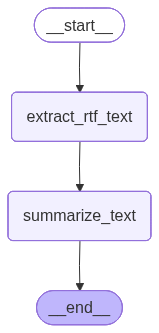

In [8]:
from IPython.display import Image, display

display(Image(first_agent.get_graph(xray=True).draw_mermaid_png()))

In [9]:
state_input = {"url": url2}
result = first_agent.invoke(state_input)

result

{'url': 'http://od.reyestr.court.gov.ua/files/58/6c270e909170b7e67afc1ec93ef5cabe.rtf',
 'text': 'Справа № 756/16936/23\n                                                        \n\nУКРАЇНА\n\nУХВАЛА\nІМЕНЕМ УКРАЇНИ\n(вступна та резолютивна частина)\n\n01 січня 2024 року місто Київ\n\nСлідчий суддя Оболонського районного суду м. Києва ОСОБА_1 , за участі секретаря судового засідання ОСОБА_2 ,  прокурора Оболонської окружної прокуратури міста Києва ОСОБА_3 , власника майна ОСОБА_4 , розглянувши у відкритому судовому засіданні в залі суду м. Києва клопотання прокурора Оболонської окружної прокуратури міста Києва ОСОБА_3 , про арешт майна у кримінальному проваджені, відомості про яке внесено до Єдиного реєстру досудових розслідувань за № 12023100050004361 від 28.12.2023 за ознаками кримінального правопорушення, передбаченого ч. 3 ст. 190 КК України,\n\nУСТАНОВИВ:\n\nУ зв`язку із тим, що складання судового рішення у формі ухвали вимагає значного часу, суд на підставі ч.2 ст.376 КПК України 

# Second Agent

In [34]:
class AgentState(TypedDict):
    messages: Annotated[list[AnyMessage], add_messages]

In [35]:
def extract_rtf_text(url: str) -> str:
    """
    Download an RTF document from the given URL and extract plain text from it.
    """

    # url = state["url"]
    response = requests.get(url)
    response.raise_for_status()

    rtf_content = response.content.decode("utf-8", errors="ignore")

    text = rtf_to_text(rtf_content)
    return  text


def summarize_text(text: str) -> str:
    """
    Generate a short Ukrainian summary for the given text using an LLM model.
    """

    summarization_prompt = PromptTemplate.from_template(summary_prompt)
    chain = summarization_prompt | model
    response = chain.invoke({"text": text})

    return response.content


tools = [extract_rtf_text, summarize_text]

llm_with_tools = model.bind_tools(tools, parallel_tool_calls=False)

In [36]:
from langchain_core.messages import AnyMessage, SystemMessage, HumanMessage


def router(state: AgentState):
    textual_description_of_tool="""
    extract_rtf_text(url: str) -> str:

    Download an RTF document from the given URL and extract plain text from it.

    Args:
        url (str): The URL of the RTF document.

    Returns:
        str: The extracted plain text from the given URL

    summarize_text(text: str) -> str:
    
    Summarizes the given text using the LLM.
    
    Args:
        text (str): The text to summarize.
        
    Returns:
        str: The summary of the text.
"""

    prompt = f"""
    You are a helpful assistant. You can analyse summarize texts (legal cases)
      and run computations with provided tools:\n{textual_description_of_tool} \n 
"""
    
    sys_msg = SystemMessage(content=prompt)

    return {
        "messages": [llm_with_tools.invoke([sys_msg] + state["messages"])],
    }

In [37]:
from langgraph.prebuilt import ToolNode, tools_condition

builder = StateGraph(AgentState)

builder.add_node("router", router)
builder.add_node("tools", ToolNode(tools))

builder.add_edge(START, "router")
builder.add_conditional_edges(
    "router",
    # If the latest message requires a tool, route to tools
    # Otherwise, provide a direct response
    tools_condition,
)
builder.add_edge("tools", "router")
react_graph = builder.compile()

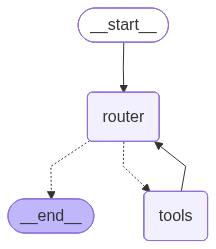

In [38]:
from IPython.display import Image, display

display(Image(react_graph.get_graph(xray=True).draw_mermaid_png()))

In [39]:
messages = [HumanMessage(content=f"сумаризуй цей документ {url2}")]
messages = react_graph.invoke({"messages": messages})

In [40]:
for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

сумаризуй цей документ http://od.reyestr.court.gov.ua/files/58/6c270e909170b7e67afc1ec93ef5cabe.rtf
================================== Ai Message ==================================
Tool Calls:
  extract_rtf_text (call_33xXMm9u61XSxjOcDAlYGpXw)
 Call ID: call_33xXMm9u61XSxjOcDAlYGpXw
  Args:
    url: http://od.reyestr.court.gov.ua/files/58/6c270e909170b7e67afc1ec93ef5cabe.rtf
================================= Tool Message =================================
Name: extract_rtf_text

Справа № 756/16936/23
                                                        

УКРАЇНА

УХВАЛА
ІМЕНЕМ УКРАЇНИ
(вступна та резолютивна частина)

01 січня 2024 року місто Київ

Слідчий суддя Оболонського районного суду м. Києва ОСОБА_1 , за участі секретаря судового засідання ОСОБА_2 ,  прокурора Оболонської окружної прокуратури міста Києва ОСОБА_3 , власника майна ОСОБА_4 , розглянувши у відкритому судовому засіданні в залі суду м.

# MCP Graph

In [44]:
from langchain_mcp_adapters.client import MultiServerMCPClient
from typing import List, TypedDict, Annotated, Optional
from langchain_core.messages import AnyMessage, SystemMessage, HumanMessage
from langgraph.graph.message import add_messages

mcp_config = {
    "postgres": {
        "transport": "sse",
        "url": "http://127.0.0.1:8000/sse" 
    }
}

_client = None

def get_mcp_client():
    """Get or initialize MCP client lazily to avoid issues with LangGraph Platform."""
    global _client
    if _client is None:
        _client = MultiServerMCPClient(mcp_config)
    return _client


client = get_mcp_client()
mcp_tools = await client.get_tools()

In [52]:
from langchain_core.tools import tool

@tool
def extract_rtf_text(url: str) -> str:
    """
    Download an RTF document from the given URL and extract plain text from it.
    """
    response = requests.get(url)
    response.raise_for_status()

    rtf_content = response.content.decode("utf-8", errors="ignore")

    text = rtf_to_text(rtf_content)
    return text


mcp_tools.append(extract_rtf_text)

In [54]:
class AgentState(TypedDict):
    messages: Annotated[list[AnyMessage], add_messages]

In [55]:
async def router(state: AgentState):
    prompt = f"""
    You are a helpful assistant. You can analyse summarize texts (court cases) and run computations with provided tools
"""
    sys_msg = SystemMessage(content=prompt)
    response = model.bind_tools(mcp_tools).invoke([sys_msg]+state["messages"])
    return {"messages": response}

In [ ]:
from langgraph.graph import StateGraph, MessagesState, START
from langgraph.prebuilt import ToolNode, tools_condition

builder = StateGraph(MessagesState)
builder.add_node(router)
builder.add_node(ToolNode(mcp_tools))
builder.add_edge(START, "router")
builder.add_conditional_edges(
    "router",
)
builder.add_edge("tools", "router")
graph = builder.compile()

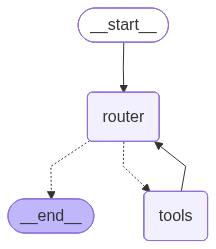

In [57]:
from IPython.display import Image, display

display(Image(graph.get_graph(xray=True).draw_mermaid_png()))

In [ ]:
q = await graph.ainvoke({"messages": "скільки записів є по справі 136/1512/24?"})

In [ ]:
for i in q['messages']:
    i.pretty_print()

================================ Human Message =================================

скільки записів є по справі 136/1512/24?
================================== Ai Message ==================================
Tool Calls:
  list_schemas (call_4NZCyggvO724DqjmpFHVrJBy)
 Call ID: call_4NZCyggvO724DqjmpFHVrJBy
  Args:
================================= Tool Message =================================
Name: list_schemas

[{'schema_name': 'information_schema', 'schema_owner': 'kaliani', 'schema_type': 'System Information Schema'}, {'schema_name': 'pg_catalog', 'schema_owner': 'kaliani', 'schema_type': 'System Schema'}, {'schema_name': 'pg_toast', 'schema_owner': 'kaliani', 'schema_type': 'System Schema'}, {'schema_name': 'public', 'schema_owner': 'pg_database_owner', 'schema_type': 'User Schema'}]
================================== Ai Message ==================================
Tool Calls:
  list_objects (call_njcTVIpV6hb9PCtOYMQChrlU)
 Call ID: call_njcTVIpV6hb9PCtOYMQChrlU
  Args:
    schema_name: 

In [61]:
q = await graph.ainvoke({"messages": "скільки записів є по справі 136/1512/24 в таблиці documents?"})

In [62]:
for i in q['messages']:
    i.pretty_print()

================================ Human Message =================================

скільки записів є по справі 136/1512/24 в таблиці documents?
================================== Ai Message ==================================
Tool Calls:
  list_schemas (call_4NbMjqqnI5UpgEY3cUNzEqQk)
 Call ID: call_4NbMjqqnI5UpgEY3cUNzEqQk
  Args:
================================= Tool Message =================================
Name: list_schemas

[{'schema_name': 'information_schema', 'schema_owner': 'kaliani', 'schema_type': 'System Information Schema'}, {'schema_name': 'pg_catalog', 'schema_owner': 'kaliani', 'schema_type': 'System Schema'}, {'schema_name': 'pg_toast', 'schema_owner': 'kaliani', 'schema_type': 'System Schema'}, {'schema_name': 'public', 'schema_owner': 'pg_database_owner', 'schema_type': 'User Schema'}]
================================== Ai Message ==================================
Tool Calls:
  list_objects (call_g5Jckw8K7E7ypWcFBT1U0LUR)
 Call ID: call_g5Jckw8K7E7ypWcFBT1U0LUR
  Arg

In [63]:
qq = """
знайди в таблиці documents doc_id 120887237 та 120879576
дістань url з doc_url поля і вивантаж ці тексти порівняй їх
і поясни в чому вони схожі 
"""

q = await graph.ainvoke({"messages": qq})

In [64]:
for i in q['messages']:
    i.pretty_print()

================================ Human Message =================================


знайди в таблиці documents doc_id 120887237 та 120879576
дістань url з doc_url поля і вивантаж ці тексти порівняй їх
і поясни в чому вони схожі 

================================== Ai Message ==================================
Tool Calls:
  execute_sql (call_VgQTHfhBG2MZghD44rU0xua2)
 Call ID: call_VgQTHfhBG2MZghD44rU0xua2
  Args:
    sql: SELECT doc_url FROM documents WHERE doc_id = 120887237;
  execute_sql (call_3YzUE3an84g7dlv6zjrlRZHx)
 Call ID: call_3YzUE3an84g7dlv6zjrlRZHx
  Args:
    sql: SELECT doc_url FROM documents WHERE doc_id = 120879576;
================================= Tool Message =================================
Name: execute_sql

[{'doc_url': 'http://od.reyestr.court.gov.ua/files/60/4f92f26de65a221c48b7c6f7d74ee9bc.rtf'}]
================================= Tool Message =================================
Name: execute_sql

[{'doc_url': 'http://od.reyestr.court.gov.ua/files/60/70528f94d4b8

In [68]:
qq = """
знайди всі рішення по cause_num 490/309/24 із documents
та сумаризуй всі документи в один висновок
"""

q = await graph.ainvoke({"messages": qq})